In [6]:
import kagglehub
import pandas as pd
import numpy as np
from kagglehub import KaggleDatasetAdapter


path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")

df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [7]:
df['Born'] = pd.to_datetime(df['Born'], format='%y-%m-%d')
df_clean = df.fillna(0)
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean = df_clean.drop("Born", axis=1)

In [8]:
from sklearn.model_selection import train_test_split

TARGET_NAME = "Salary"
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- Baseline LinearRegreesion (Raw Data) ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"Для сравнения: если всегда предсказывать среднее, MAE = {base_mean_error:.3f}")

--- Baseline LinearRegreesion (Raw Data) ---
MAE (Ошибка в долларах): 1381895.059
RMSE: 1931946.767
R2 Score: 0.324
Для сравнения: если всегда предсказывать среднее, MAE = 1877717.767


Базовый линейный регрессор выдал результаты хуже, чем KNN, интересно. В целом может и логично, потому что похожие игроки в НХЛ по качеству должны зарабатывать примерно одинаково, что буквально есть KNN. Попробуем оптимизировать.

In [133]:
import kagglehub
from kagglehub import KaggleDatasetAdapter


path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")
df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)

In [134]:
df['Born'] = pd.to_datetime(df['Born'], format='%y-%m-%d')
reference_date = pd.Timestamp('2016-10-01') # начало сезона
df['Age'] = (reference_date - df['Born']).dt.days / 365.25
df['Experience'] = reference_date.year - df['DftYr']
df['Age_squared'] = df['Age'] ** 2

features_to_drop = ['Born', 'Last Name', 'First Name', 'Nat', 'Pr/St', 'DftRd', 'TOI/GP.1']
df_drop_unneeded = df.drop(features_to_drop, axis=1)
df_drop_unneeded['Match'].value_counts()

Match
0    870
1      4
Name: count, dtype: int64

In [ ]:
X = df_drop_unneeded.drop(TARGET_NAME, axis=1)
y = df_drop_unneeded[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [147]:

from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, QuantileTransformer, StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

normal_candidates = ["Ht", "Wt", "+/-", "E+/-", "TOI%", "SH%", "SV%", "F/60",
                     "A/60", "Diff/60", "iHDf", "iPenDf", "NPD"]

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

excluded_cols = cat_cols
normal_cols = [c for c in normal_candidates if c in X.columns and c not in excluded_cols]
power_cols = [c for c in X.columns if c not in normal_cols]

all_processed_cols = normal_cols + cat_cols
power_cols = [c for c in X.columns if c not in all_processed_cols]
power_cols = [c for c in power_cols if c in X.select_dtypes(include=np.number).columns]

cat_branch = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

poly_branch = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', StandardScaler())
])

normal_branch = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', StandardScaler())
])

power_branch = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', PowerTransformer())
])

ct = ColumnTransformer(
    transformers=[
        ("cat_proc", cat_branch, cat_cols),
        ("normal_proc", normal_branch, normal_cols),
        ("power_proc", power_branch, power_cols),
    ], remainder='drop'
)

In [148]:
full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=Ridge(),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'preprocessor__normal_proc__scaler': [
        StandardScaler(),
        RobustScaler(),
        MinMaxScaler(),
        PowerTransformer(),
        QuantileTransformer()
    ],
    'preprocessor__power_proc__scaler': [
        StandardScaler(),
        RobustScaler(),
        MinMaxScaler(),
        PowerTransformer(),
        QuantileTransformer()
    ],
    'model_wrapper__regressor__alpha': [0.1, 1.0, 10.0, 50.0]
}

grid = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))

print(f"\n--- Ridge Regression с Polynomial Features ---")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"MAE для baseline (среднее): {base_mean_error:.3f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (488). n_quantiles is set to n_samples.
  warnings.warn(
/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (489). n_quantiles is set to n_samples.
  warnings.warn(
/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (489). n_quantiles is set to n_samples.
  warnings.warn(
/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (489). n_quantiles is set to n_samples.
  warnings.wa

{'model_wrapper__regressor__alpha': 1.0, 'preprocessor__normal_proc__scaler': MinMaxScaler(), 'preprocessor__power_proc__scaler': QuantileTransformer()}

--- Ridge Regression с Polynomial Features ---
MAE: 867148.853
RMSE: 1357967.857
R2 Score: 0.666
MAE для baseline (среднее): 1877717.767


/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (611). n_quantiles is set to n_samples.
  warnings.warn(


Чисто визуально, стало лучше на почти 1023870.276 - 867148.853 = 145k$ по сравнении с KNN. Это успех.

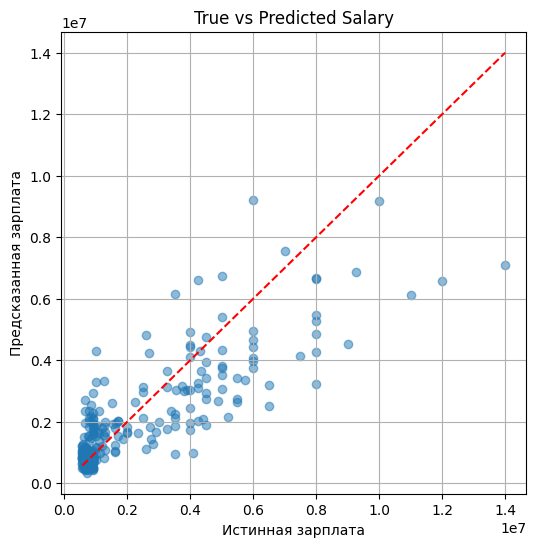

In [149]:
from matplotlib import pyplot as plt


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Истинная зарплата")
plt.ylabel("Предсказанная зарплата")
plt.title("True vs Predicted Salary")
plt.grid(True)
plt.show()

Данные стали сильно более кучнее относительно идеальной оси. Это хорошо. Плохо то, что модель всё еще плохо справляется с "выбросами" по зарплате. Если у игрока она очень большая относительно массы, модели сложно определить реальную стоимость и она в основном занижает ее.

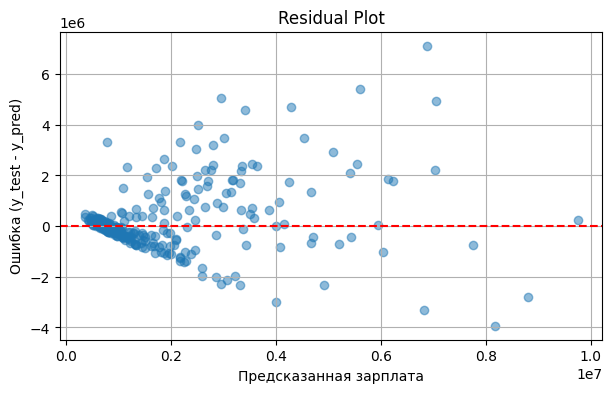

In [144]:
residuals = y_test - y_pred

plt.figure(figsize=(7,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Предсказанная зарплата")
plt.ylabel("Ошибка (y_test - y_pred)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

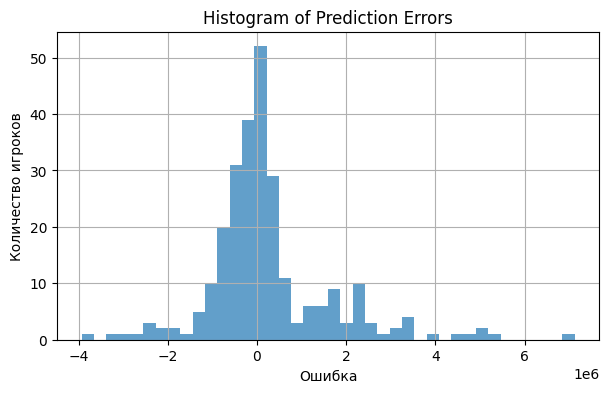

In [145]:
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.title("Histogram of Prediction Errors")
plt.xlabel("Ошибка")
plt.ylabel("Количество игроков")
plt.grid(True)
plt.show()

In [160]:
import pandas as pd
import numpy as np

original_float_format = pd.get_option('display.float_format')

pd.set_option('display.float_format', '{:.2f}'.format)

best_model = grid.best_estimator_

y_full_pred = best_model.predict(X)

results_df = pd.DataFrame({
    'True_Salary': y,
    'Predicted_Salary': y_full_pred
})

results_df['Absolute_Error'] = np.abs(results_df['True_Salary'] - results_df['Predicted_Salary'])

test_indices = X_test.index
final_results = pd.merge(
    df[['First Name', 'Last Name']],
    results_df,
    left_index=True,
    right_index=True
)

final_results_sorted = final_results.sort_values(by='Absolute_Error', ascending=False)

print("\n--- 📝 Топ-10 игроков с наибольшей ошибкой (Train & Test) ---")
print(final_results_sorted.head(10).to_string())

pd.set_option('display.float_format', original_float_format)


--- 📝 Топ-10 игроков с наибольшей ошибкой (Train & Test) ---
    First Name Last Name  True_Salary  Predicted_Salary  Absolute_Error
103    Patrick      Kane  13800000.00        6618003.56      7181996.44
626       Anze   Kopitar  14000000.00        7087130.29      6912869.71
817     Steven   Stamkos   9500000.00        3185053.37      6314946.63
496   Jonathan     Toews  13800000.00        7708177.96      6091822.04
542       Shea     Weber  12000000.00        6587381.75      5412618.25
861      Corey     Perry  10000000.00        4657873.37      5342126.63
837       Ryan  O'Reilly  11000000.00        5820051.09      5179948.91
208       P.K.    Subban  11000000.00        6105357.47      4894642.53
497     Andrew      Ladd   8000000.00        3237805.99      4762194.01
564       Ryan  Callahan   6500000.00        1920925.29      4579074.71


Человек, у которого самая "переоценненая" зарплата в НХЛ на сезон 2016-2017 -- это Анжи Копитар. По статистике, сезон 2016/2017 вышел для Копитара худшим за всю карьеру по очкам, не считая сезон с травмой, где он провёл всего 47 очков (при 42 играх), то есть 1.11 очка за игру против 52 очка (при 76 игре), то есть 0.68 очка за игру.

In [162]:
import pandas as pd
final_results['Signed_Error'] = final_results['Predicted_Salary'] - final_results['True_Salary']

overestimated_players = final_results[final_results['Signed_Error'] > 0].copy()

top_overestimated = overestimated_players.sort_values(by='Signed_Error', ascending=False)

print("\n--- ⬆️ Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---")

print(top_overestimated[['First Name', 'Last Name',
                         'True_Salary', 'Predicted_Salary', 'Signed_Error']].head(10).to_string())


--- ⬆️ Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---
    First Name Last Name  True_Salary  Predicted_Salary  Signed_Error
830    Patrick     Eaves   1000000.00        5108535.29    4108535.29
110       Luke    Schenn   1000000.00        4295155.21    3295155.21
299     Duncan     Keith   6000000.00        9194761.34    3194761.34
131    Jaromir      Jagr   4000000.00        7122007.84    3122007.84
216      Mikko     Koivu   5400000.00        8400722.70    3000722.70
326     Martin    Hanzal   3500000.00        6147571.61    2647571.61
286     Victor    Hedman   4250000.00        6597264.98    2347264.98
223       Kyle    Turris   4000000.00        6315842.08    2315842.08
36       Roman      Josi   4250000.00        6542581.13    2292581.13
532      Radim    Vrbata   1000000.00        3288792.81    2288792.81


А самым недооценненым стал Патрик Ивс, сезон 2016-2017 стал для него прорывным после обмена в Даллас.